In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [11]:
computer = pd.read_csv('computer_subcategory_classification.csv',names=['website_url','cleaned_website_text','Category'],header=None)
computer.drop([0],inplace=True)
computer.reset_index(drop=True,inplace=True)
computer.head()

,website_url,cleaned_website_text,Category
0,http://www.kasrl.org/jaffe.html,japanese female facial expression jaffe datase...,Computers and Technology
1,https://www.gmdhshell.com/,best predictive analytic software free academi...,Computers and Technology
2,http://en.wikipedia.org/wiki/Neural_network,neural network wikipedia neural network conten...,Computers and Technology
3,http://cadingandcoding.blogspot.com/,cading coding cading coding tuesday march auto...,Computers and Technology
4,http://www.panzercad.com/,welcome bluehost rate web host provider free c...,Computers and Technology


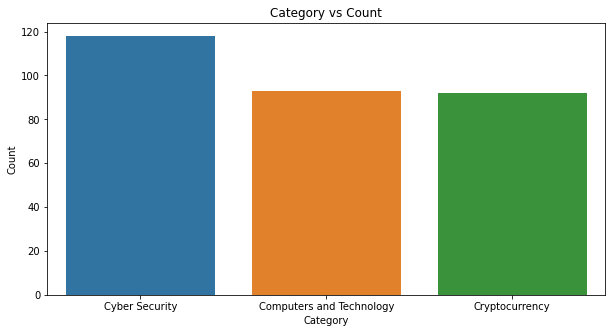

In [12]:
#Putting values into graph
plt.figure(figsize=(10,5))
plt.title("Category vs Count")
computer_category_count = pd.DataFrame(computer["Category"].value_counts())
sns.barplot(x=computer_category_count.index, y=computer_category_count["Category"])
plt.ylabel("Count")
plt.xlabel("Category")
plt.show()

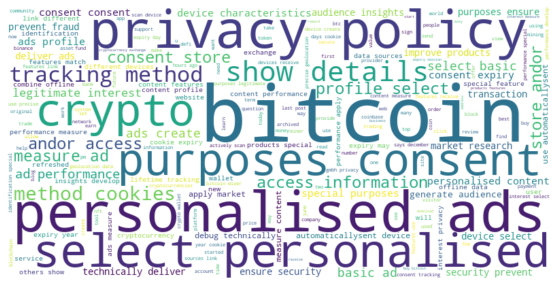

In [13]:
from wordcloud import WordCloud

category_name = "Cryptocurrency"
category_data = computer[computer["Category"]==category_name]['cleaned_website_text']
category_text = ' '.join(category_data)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(category_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Cleaning the text

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = stopwords.words('english')
import string

lem = WordNetLemmatizer()

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'
    
#Define function to lemmatize each word with its POS tag
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    pos_tagged_text = [(word, pos_tagger(pos_tag)) for word, pos_tag in pos_tagged_text]
    return [lem.lemmatize(word, pos_tag) for word, pos_tag in pos_tagged_text]

In [15]:
stop_words.extend(["decemeber","dec","january","jan","feb","february","march","mar","may","april","apr","june","jun","july","jul","august","aug","september","sept","oct","october","nov","november",
                   "one","two","three","hundred","thousand","million","billion","today","tomorow","week","month","year","sign in","login","sign up"])

stop_words.extend(['afghanistan', 'albania', 'algeria', 'andorra', 'angola', 'antigua', 'argentina', 'armenia', 'australia',
    'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'belize',
    'benin', 'bhutan', 'bolivia', 'bosnia', 'botswana', 'brazil', 'brunei', 'bulgaria', 'burkina', 'burundi',
    'cambodia', 'cameroon', 'canada', 'cape', 'central', 'chad', 'chile', 'china', 'colombia', 'comoros',
    'congo', 'costa', 'croatia', 'cuba', 'cyprus', 'czech', 'denmark', 'djibouti', 'dominica', 'dominican',
    'east', 'ecuador', 'egypt', 'el', 'equatorial', 'eritrea', 'estonia', 'ethiopia', 'fiji', 'finland',
    'france', 'gabon', 'gambia', 'georgia', 'germany', 'ghana', 'greece', 'grenada', 'guatemala', 'guinea',
    'guyana', 'haiti', 'honduras', 'hungary', 'iceland', 'india', 'indonesia', 'iran', 'iraq', 'ireland',
    'israel', 'italy', 'jamaica', 'japan', 'jordan', 'kazakhstan', 'kenya', 'kiribati', 'korea', 'kosovo',
    'kuwait', 'kyrgyzstan', 'laos', 'latvia', 'lebanon', 'lesotho', 'liberia', 'libya', 'liechtenstein',
    'lithuania', 'luxembourg', 'macedonia', 'madagascar', 'malawi', 'malaysia', 'maldives', 'mali', 'malta',
    'marshall', 'mauritania', 'mauritius', 'mexico', 'micronesia', 'moldova', 'monaco', 'mongolia', 'montenegro',
    'morocco', 'mozambique', 'myanmar', 'namibia', 'nauru', 'nepal', 'netherlands', 'new', 'nicaragua',
    'niger', 'nigeria', 'norway', 'oman', 'pakistan', 'palau', 'panama', 'papua', 'paraguay', 'peru',
    'philippines', 'poland', 'portugal', 'qatar', 'romania', 'russia', 'rwanda', 'samoa', 'san', 'sao',
    'senegal', 'serbia', 'seychelles', 'sierra', 'singapore', 'slovakia', 'slovenia', 'solomon', 'somalia',
    'south', 'spain', 'sri', 'st.', 'sudan', 'suriname', 'swaziland', 'sweden', 'switzerland', 'syria',
    'taiwan', 'tajikistan', 'tanzania', 'thailand', 'timor-leste', 'togo', 'tonga', 'trinidad', 'tunisia',
    'turkey', 'turkmenistan', 'tuvalu', 'uganda', 'ukraine', 'united', 'uruguay', 'uzbekistan', 'vanuatu',
    'vatican', 'venezuela', 'vietnam', 'yemen', 'zambia', 'zimbabwe'])

stop_words.extend([
    'dollar', 'euro', 'pound', 'rupee', 'yen', 'yuan', 'won', 'franc', 'dinar', 'peso', 'lira', 'rupee', 'ruble',
    'koruna', 'baht', 'real', 'zloty', 'rand', 'shekel', 'krona', 'dirham', 'forint', 'colón', 'hryvnia',
    'leu', 'ringgit', 'kuna', 'lempira', 'cordoba', 'kwacha', 'taka', 'quetzal', 'birr', 'rial', 'tenge',
    'shilling', 'kwacha', 'naira', 'rial', 'dinar', 'rupiah', 'pula', 'riyal', 'dinar', 'lilangeni', 'krona',
    'franc', 'syli', 'peso', 'shilling', 'baht', 'vatu', 'bolivar', 'dong', 'rial'
])

In [16]:
from nltk import FreqDist

computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: x.lower())
computer['cleaned_website_text'] = computer['cleaned_website_text'].apply(lambda x: re.sub(r'http\S+|www\S+', ' ', x))
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: re.sub(r'[^\w\s]','',x))
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: re.sub(r'_+',' ',x))
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: re.sub(r'\d+','',x))
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: re.sub(r'\s+',' ',x))
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: word_tokenize(x))
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: [word for word in x if word not in stop_words])
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: [word for word in x if len(word) > 3])
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: lemmatize_words(x))
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: ' '.join(x))

# # Filter out infrequent words
# tokens = [word_tokenize(text) for text in computer["cleaned_website_text"]]
# word_freq = FreqDist([word for token in tokens for word in token])
# threshold_freq = 10
# computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word_freq[word] > threshold_freq]))

### Feature Extraction: Label Encoding

In [17]:
le = LabelEncoder()
computer["Category"] = le.fit_transform(computer["Category"])
computer.tail()

,website_url,cleaned_website_text,Category
298,https://bitmixing.net/,bitcoin mixer tumbler bitcoin blenderlooking t...,1
299,https://finance.yahoo.com/news/bitcoin-mixer-e...,bitcoin mixer expert introduce tumbler protect...,1
300,https://ransomwhe.re/,ransomwhereransomwhere open crowdsourced ranso...,2
301,https://altenens.is/,altenen trust safetyaltenen forum dedicate mak...,2
302,https://nulledbb.com/,nulledbbnulledbb discussion forum game technol...,2


In [18]:
#splitting dataset
X_train,X_test,y_train,y_test = train_test_split(computer["cleaned_website_text"], computer["Category"], test_size=0.2, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((242,), (61,), (242,), (61,))

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word',smooth_idf=True,max_features=5000,ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [10]:
feature_names = tfidf.get_feature_names_out()

#get IDF score
idf_score = tfidf.idf_

# Print feature names and IDF scores
for feature, score in zip(feature_names, idf_score):
    print(feature, score)

aave 4.340109689682317
abdulkarim 5.844187086458591
abdulwahab 5.844187086458591
ability 3.136136885356381
able 2.9819862055291226
abrams 5.844187086458591
absolute 4.927896354584436
absolutely 4.139438994220166
abstract 4.591424117963223
abstraction 4.927896354584436
abuga 5.844187086458591
abuse 4.052427617230537
academia 4.927896354584436
academic 3.8982769374032777
academy 4.234749174024491
accelerate 3.592895287852096
accept 2.687186665308478
acceptance 4.4578927253387
accepts 5.151039905898646
access 1.6931471805599454
accessibility 3.4462918136602205
accessible 3.205129756843333
accessory 4.745574797790482
accesstoken 5.438721978350427
accomplish 4.340109689682317
accord 3.2792377289970545
account 1.9123614537342655
accountcoindeskcom 5.844187086458591
accounting 5.151039905898646
accuracy 4.052427617230537
accurate 3.4928118292951136
accurately 4.340109689682317
accuse 4.927896354584436
achieve 3.359280436670591
acknowledge 4.139438994220166
acorn 5.844187086458591
acquire 4.23

### Training Model Pipeline

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have your training data (X_train) and corresponding labels (y_train)

# Define the models and their respective hyperparameters to try during grid search
models = {
    'MNB': {
        'model': MultinomialNB(),
        'params': {
            'mnb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'svm__C': [1, 10],
            'svm__kernel': ['linear', 'rbf']
        }
    },
}

# Perform grid search and cross-validation for each model
for model_name, model_data in models.items():
    print("Evaluating:", model_name)
    
    # Create a pipeline with a TF-IDF vectorizer and the current model
    pipeline = Pipeline([
        ("feature_selection", SelectKBest(score_func=chi2)),
        (model_name.lower(), model_data['model'])
    ])
    
    # Define the hyperparameters for the current model
    parameters = {
        'feature_selection__k':[1000, 2000, 3000, 4000, 5000],
        **model_data['params']
    }
    
    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy')
    grid_search.fit(X_train_tfidf, y_train)
    
    # Get the best model and its corresponding hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test_tfidf)
    
    # Calculate and print evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Best parameters:", best_params)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    print("----------------------------------")

Evaluating: MNB
Best parameters: {'feature_selection__k': 4000, 'mnb__alpha': 0.1}
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
----------------------------------
Evaluating: SVM
Best parameters: {'feature_selection__k': 1000, 'svm__C': 10, 'svm__kernel': 'linear'}
Accuracy: 0.9836065573770492
Precision: 0.9843871975019517
Recall: 0.9836065573770492
F1 score: 0.9836457573833212
----------------------------------


In [22]:
#for Multinomial Naive Bayes
from sklearn.feature_selection import chi2
chi2_selector = SelectKBest(score_func=chi2, k=4000)

X_train_selected = chi2_selector.fit_transform(X_train_tfidf, y_train)
X_test_selected = chi2_selector.transform(X_test_tfidf)


In [23]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_selected, y_train)

MultinomialNB(alpha=0.1)

In [24]:
import sklearn.metrics as sm

y_pred = model.predict(X_test_selected)

print(f'The accuracy of train model is {sm.accuracy_score(y_train,model.predict(X_train_selected))}')
print(f'The accuracy of test model is {sm.accuracy_score(y_test,y_pred)}')

The accuracy of train model is 1.0
The accuracy of test model is 1.0


In [25]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import os


class ScrapTool:   
    def visit_url(self,website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        #Set up Selenium webdriver
        PATH = 'C:/Users/User01/Downloads/chromedriver_win32/chromedriver.exe'

        # Set the Chrome webdriver options
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        # Initialize the Chrome webdriver and pass the Chrome options
        service = Service(PATH)
        driver = webdriver.Chrome(service = service, options = chrome_options)

        #Load website
        driver.get(website_url)
        
        # Check if the cookie consent button is present
        cookie_button = None
        try:
            cookie_button = WebDriverWait(driver, 15).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "cookie-consent-button")))
        except:
            pass

        # Handle cookies if the button is present
        if cookie_button:
            cookie_button.click()

        # Extract HTML content
        html_content = driver.page_source
        driver.quit()

        soup = BeautifulSoup(html_content,'lxml')
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                    self.get_text_content(soup)
        }
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(text=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

In [32]:
def cleaning(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'_+',' ',text)
    text = re.sub(r'\d+','',text)
    text = re.sub(r'\s+',' ',text)
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    text = [word for word in text if len(word)>3]
    text = lemmatize_words(text)
    text = ' '.join(text)
    vector = tfidf.transform([text])
    vector = chi2_selector.transform(vector)
    vector = vector.toarray()
    
    return vector

from darkwebScrapper import Scraper

def website_prediction(website,model,dark_web):
    try:
        if dark_web:
            text = Scraper(website,dark_web=dark_web)
            text = cleaning(text)
        else:
            scrapTool = ScrapTool()
            web = dict(scrapTool.visit_url(website))
            text = cleaning(web['website_text'])
            
        prediction = model.predict(text)
        print(f'The website is under the category of {le.inverse_transform(prediction)[0]}')
    except Exception as e:
        print(e)
        print("Connection Timeout")

                          precision    recall  f1-score   support

Computers and Technology       1.00      1.00      1.00        20
          Cryptocurrency       1.00      1.00      1.00        15
          Cyber Security       1.00      1.00      1.00        26

                accuracy                           1.00        61
               macro avg       1.00      1.00      1.00        61
            weighted avg       1.00      1.00      1.00        61



<AxesSubplot:>

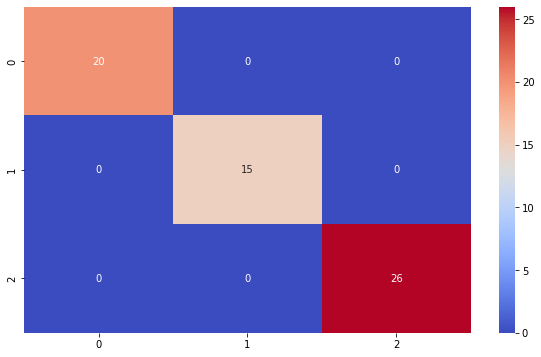

In [33]:
plt.figure(figsize=(10,6))
predictions = model.predict(X_test_selected)
print(classification_report(le.inverse_transform(predictions),le.inverse_transform(y_test)))
sns.heatmap(confusion_matrix(predictions,y_test),cmap='coolwarm',annot=True)

In [28]:
pd.set_option('display.max_rows', None)
predictions = model.predict(X_test_selected)
results = pd.DataFrame({'Cleaned Text':X_test,'Actual':y_test,'Predicted':predictions})
results[results['Actual']!=results['Predicted']]

,Cleaned Text,Actual,Predicted


In [34]:
website_prediction("https://altenens.is/",model,False)

The website is under the category of Cyber Security


                          precision    recall  f1-score   support

Computers and Technology       1.00      0.95      0.97        19
          Cryptocurrency       1.00      1.00      1.00        21
          Cyber Security       0.96      1.00      0.98        24

                accuracy                           0.98        64
               macro avg       0.99      0.98      0.98        64
            weighted avg       0.98      0.98      0.98        64



<AxesSubplot:>

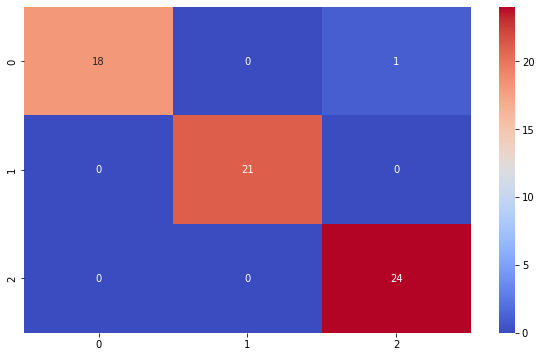

In [20]:
#Checking for SVM model
from sklearn.feature_selection import chi2
chi2_selector = SelectKBest(score_func=chi2, k=2000)

X_train_selected = chi2_selector.fit_transform(X_train_tfidf, y_train)
X_test_selected = chi2_selector.transform(X_test_tfidf)

model2 = SVC(C=1,kernel='rbf')

model2.fit(X_train_selected,y_train)

plt.figure(figsize=(10,6))
predictions = model2.predict(X_test_selected)
print(classification_report(le.inverse_transform(predictions),le.inverse_transform(y_test)))
sns.heatmap(confusion_matrix(predictions,y_test),cmap='coolwarm',annot=True)

In [21]:
# import pickle

# filename = 'CompSubCat.sav'
# pickle.dump(model, open(filename, 'wb'))

# #loading the model
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test_selected, y_test)
# print(result)

ValueError: X has 2000 features, but MultinomialNB is expecting 5000 features as input.

In [36]:
import pickle
loaded_model = pickle.load(open("./model/CompSubCat_MNB.sav", 'rb'))
loaded_model2 = pickle.load(open("./model/CompSubCat_SVM.sav", 'rb'))

In [41]:
website_prediction("http://allbits7fuboct7q6dzht5yfwwdwigmesy45fctinesvxwgithpn2fyd.onion",loaded_model,True)
website_prediction("http://uw6wxgibykcokqpyyqfmdijkwaukkxcey3sb6bnhvy2mq4cbjpwfsrid.onion/post/9yejhiofi1s8oqsbftpd",loaded_model,True)
website_prediction("http://snuul35t67fz5gyuv5ah6uzcc2djc56hac767zc7ppxgltgz3dhbn2id.onion/post/ven7dtksxfaojomc5xur/?sort=new",loaded_model,True)
website_prediction("http://2a2a26dhzrdaecn7kojyfoza3usvmzovtefsgghblbpckgkdqoavpmid.onion/shop/counterfeits/1-btc-bitcoin-wallet-limited-stock-%e2%98%85-vendor-of-the-month-%e2%98%85/comment-page-15/",loaded_model,True)

Getting... http://allbits7fuboct7q6dzht5yfwwdwigmesy45fctinesvxwgithpn2fyd.onion
The website is under the category of Cryptocurrency
Getting... http://uw6wxgibykcokqpyyqfmdijkwaukkxcey3sb6bnhvy2mq4cbjpwfsrid.onion/post/9yejhiofi1s8oqsbftpd
The website is under the category of Cryptocurrency
Getting... http://snuul35t67fz5gyuv5ah6uzcc2djc56hac767zc7ppxgltgz3dhbn2id.onion/post/ven7dtksxfaojomc5xur/?sort=new
The website is under the category of Cryptocurrency
Getting... http://2a2a26dhzrdaecn7kojyfoza3usvmzovtefsgghblbpckgkdqoavpmid.onion/shop/counterfeits/1-btc-bitcoin-wallet-limited-stock-%e2%98%85-vendor-of-the-month-%e2%98%85/comment-page-15/
The website is under the category of Cryptocurrency


In [31]:
import pickle

filename = './model/CompSubCat_MNB.sav'
vectorizer = './model/vectorizer.pkl'
selector = './model/selector.pkl'
pickle.dump(model, open(filename, 'wb'))
pickle.dump(tfidf, open(vectorizer, 'wb'))
pickle.dump(chi2_selector, open(selector, 'wb'))

#loading the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_selected, y_test)
print(result)

1.0
